### Classify movies genres from text data

For this project I used data from Imdb.com website. The goal of this project is to try and see if it is possible to classify movies genres from text data.

The data I am going to use is scraped from IMDB. There are two movie descriptions on the website:

- Short summary which is 50-200 symbols long.
- Synopsis which is 500-10000 symbols long.

Dataset contains much more summaries while synopsises contain more information. Lets experiment with both and see which one works better.

This is a multilabel classification problem which means that more than one genre can be assigned to a movie. To solve this problem I am going to use Recurrent Neural Networks (RNN) with Keras.

What needs to be done:

- Clean text and get rid of stopwords.
- Create bigrams and apply them to text.
- Perform stemming and lemmatization.
- Build vocabulary from text corpus and assign vectors to words usind Word2vec library.
- One hot encode genres and transform texts into sequences of numbers.
- Build a RNN model using LSTM hidden layers
- Evaluate model on different levels of acceptance and find the best one.

## Load and clean Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
current_palette = sns.color_palette('deep')

In [2]:
df = pd.read_csv('imdb_data_update.csv')
df.head()

c:\users\13479\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,title,year,mpaa,run_time,rating,ratings_count,budget,world_gross,genre,director,writer,actor,keywords,summary,synopsis
0,Dama de noche,1993,NaN,NaN,6.2,20,NaN,NaN,"['Drama', 'Mystery', 'Romance', 'Thriller']",Eva López Sánchez,"Eva López Sánchez,David Martin del Campo(novel)","Rafael Sánchez Navarro,Cecilia Toussaint,Migue...","['f rated', 'older man younger woman relations...",Add a Plot»,It looks like we don't have a Synopsis for thi...
1,Kate & Leopold,2001,PG-13,118123,6.4,"77,418",4.8e+07,76019048.0,"['Comedy', 'Fantasy', 'Romance']",James Mangold,"Steven Rogers(story),James Mangold(screenplay)","Meg Ryan,Hugh Jackman,Liev Schreiber","['time travel', 'brooklyn bridge', 'bridge', '...",An English Duke from 1876 is inadvertedly drag...,"In 1876, Leopold Alexis Elijah Walker Gareth T..."
2,The Woman with the Knife,2010,NaN,80,6.6,10,NaN,NaN,"['Drama', 'Thriller']",Bassori Timite,Bassori Timite(as Timité Bassori),"Bassori Timite,Mary Vieyra,Danielle Alloh",['sexual'],A young man returns from Europe obsessed with ...,It looks like we don't have a Synopsis for thi...
3,"Vojtech, receny sirotek",1990,NaN,80,6.5,24,NaN,NaN,['Drama'],Zdenek Tyc,"Jaromir Kacer(screenplay),Jirí Soukup(screenplay)","Petr Forman,Barbora Lukesová,Jana Riháková","['skinny dipping', 'male nudity', 'male fronta...",Add a Plot»,It looks like we don't have a Synopsis for thi...
4,Ucho,1990,NaN,94,7.8,"2,367",NaN,NaN,"['Drama', 'Thriller']",Karel Kachyna,"Karel Kachyna,Jan Procházka(screenplay)","Jirina Bohdalová,Radoslav Brzobohatý,Gustav Op...","['czech new wave', 'sleeplessness', 'power fai...",After coming home from a Party gathering one n...,It looks like we don't have a Synopsis for thi...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96695 entries, 0 to 96694
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          96679 non-null  object 
 1   year           96695 non-null  object 
 2   mpaa           14875 non-null  object 
 3   run_time       80015 non-null  object 
 4   rating         96695 non-null  float64
 5   ratings_count  96695 non-null  object 
 6   budget         28461 non-null  object 
 7   world_gross    32220 non-null  float64
 8   genre          95463 non-null  object 
 9   director       96695 non-null  object 
 10  writer         96695 non-null  object 
 11  actor          96695 non-null  object 
 12  keywords       76765 non-null  object 
 13  summary        96695 non-null  object 
 14  synopsis       96695 non-null  object 
dtypes: float64(2), object(13)
memory usage: 11.1+ MB


In [4]:
years = np.arange(1990, 2021)
years = [str(year) for year in years] # getting rid of weird string values 
df = df[df['year'].isin(years)]
df.year = df.year.astype('int64') # making year column a proper type

In [5]:
def clean_summary(string):
    
    '''replaces unnecessary string from summary ending '''
    
    string = string.replace('...See full summary»', '').replace("\'", '')
    return string

In [6]:
df.summary = df.summary.apply(clean_summary)

In [7]:
# df.rating = df.rating.apply(round_of_rating)
# df.ratings_count = df.ratings_count.map(lambda x: x.replace(',', ''))
# df.ratings_count = df.ratings_count.astype('int64')
# df = df[df.ratings_count > 100]

In [8]:
# make separate df for synopsis
null = 'It looks like we don\'t have a Synopsis for this title yet.Be the first to contribute! Just click the "Edit page" button at the bottom of the page or learn more in theSynopsis submission guide.'
df_syn = df[df.synopsis != null].reset_index(drop=True)

I am going to make two dataframes: one with short summaries and one with synopsises. 

In [9]:
df_tri = df[['genre','summary']]
df_syn = df_syn[['genre', 'synopsis']]
df_tri = df_tri.dropna()
df_syn = df_syn.dropna()

In [10]:
df_tri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95218 entries, 0 to 96694
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   genre    95218 non-null  object
 1   summary  95218 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


In [11]:
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11429 entries, 0 to 11454
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genre     11429 non-null  object
 1   synopsis  11429 non-null  object
dtypes: object(2)
memory usage: 267.9+ KB


In [12]:
to_drop = 'Add a Plot»' # get rid of null values
df_tri = df_tri[df_tri.summary != to_drop].reset_index(drop=True)

In [13]:
len(df_tri)

86104

## Text Cleaning

In [14]:
import nltk

In [15]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder 
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet 

In [16]:
def tokenize(string, lemmatize=False, stem=False):
    
    '''removes stopwords, symbols and integers'''
    
    tokens = nltk.word_tokenize(string.replace("'", ""))

    tokens = [token.lower() for token in tokens if token.isalpha()]
    
    eng_stopwords = stopwords.words('english')
    
    tokens = [w for w in tokens if w not in eng_stopwords]
    
    if lemmatize:
        tokens = lemmatize_list(tokens)
        
    if stem:
        tokens = stem_list(tokens)

    return tokens

In [17]:
def clean_text(string, bigrams=None, lemmatize=False, stem=False):
    
    '''Cleans string and applies bigrams'''
    
    if bigrams:
    
        for k in bigrams:
            string = string.lower().replace(k,bigrams[k])
    
    tokens = tokenize(string, lemmatize=lemmatize, stem=stem)
    
    [token for token in tokens if len(token)>2]
    
    tokens = ' '.join(tokens)
    
    return tokens

In [18]:
def find_bigrams(text, num_of_bigrams=40):
    
    '''Finds bigrams in text
       Returns phrases + bigrams in dictionary form'''
    
    tokens = tokenize(text)
    
    bigram_collocation = BigramCollocationFinder.from_words(tokens) 
    bigrams = bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, num_of_bigrams) 
    
    vals = [''.join(x) for x in bigrams]
    keys = [' '.join(x) for x in bigrams]
    
    replacement_dict = {}
    
    for key, val in zip(keys, vals):
        replacement_dict[key] = val
    
    return replacement_dict

In [19]:
def lemmatize_list(words):
    
    '''lemmatizes words'''
    
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(x) for x in words]
    
    return lemma    

In [20]:
def stem_list(words):
    
    '''Performs stemming'''
    
    ps = PorterStemmer()
    
    stemmed = [ps.stem(x) for x in words]
    
    return stemmed    

## Summary cleaning

In [21]:
# text = ' '.join(df_tri.summary)

# bigrams = find_bigrams(text, 30)
# print(bigrams)

bigrams = {'high school': 'highschool', 'new york': 'newyork', 'los angeles': 'losangeles',
           'falls love': 'fallslove', 'serial killer': 'serialkiller', 'small town': 'smalltown',
           'young woman': 'youngwoman', 'young man': 'youngman', 'year old': 'yearold',
           'best friend': 'bestfriend', 'hong kong': 'hongkong', 'one day': 'oneday',
           'tells story': 'tellsstory', 'full synopsis': 'fullsynopsis', 'years ago': 'yearsago',
           'road trip': 'roadtrip', 'revolves around': 'revolvesaround', 'york city': 'yorkcity',
           'police officer': 'policeofficer', 'best friends': 'bestfriends', 'see full': 'seefull',
           'years later': 'yearslater', 'united states': 'unitedstates', 'martial arts': 'martialarts',
           'fall love': 'falllove', 'war ii': 'warii', 'true story': 'truestory', 'buenos aires': 'buenosaires',
           'world war': 'worldwar', 'turned upside': 'turnedupside'}

In [22]:
df_tri['summary'] = df_tri['summary'].map(lambda x: clean_text(x, bigrams=None,lemmatize=False, stem=False))

df_tri['genre'] = df_tri['genre'].map(lambda x: clean_text(x))    

In [23]:
df_tri.head()

,genre,summary
0,comedy fantasy romance,english duke inadvertedly dragged modern day n...
1,drama thriller,young man returns europe obsessed sexual inhib...
2,drama thriller,coming home party gathering one night czechosl...
3,drama,hollywood director emerges plans complete work...
4,comedy crime drama family,lonely emotionally neglected rich kid forms at...


In [24]:
print(df_tri.loc[12, 'summary'])

based true story known great plane robbery tells story peter macari alias brown grand extortion scam steals cash


Let's deal with outliers

In [25]:
def length(text):
    
    '''finds length of the text'''
    
    return len(text)

In [26]:
df_tri['length'] = df_tri.summary.apply(length)

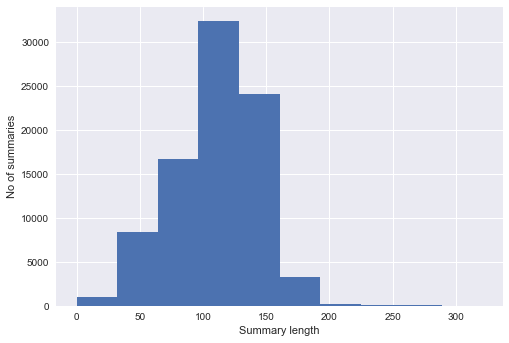

In [27]:
df_tri.length.hist()# check text length distribution
plt.xlabel('Summary length')
plt.ylabel('No of summaries')
plt.show()

In [28]:
# get rid of small texts and outliers
df_tri = df_tri[df_tri.length >= 40]
df_tri = df_tri[df_tri.length < 200].reset_index(drop=True)

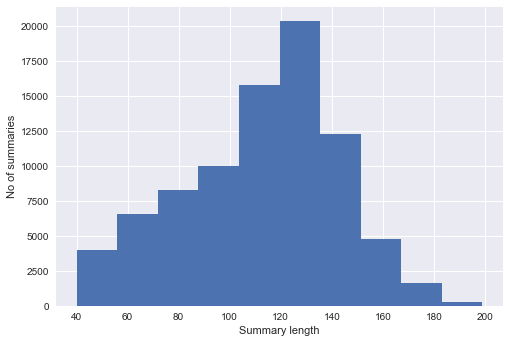

In [29]:
df_tri.length.hist()
plt.xlabel('Summary length')
plt.ylabel('No of summaries')
plt.show()

In [30]:
df_tri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83996 entries, 0 to 83995
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   genre    83996 non-null  object
 1   summary  83996 non-null  object
 2   length   83996 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [31]:
distrib = []
for genre in df_tri.genre:
    for i in genre.split():
        distrib.append(i)
        
from collections import Counter

distrib = dict(Counter(distrib).most_common())

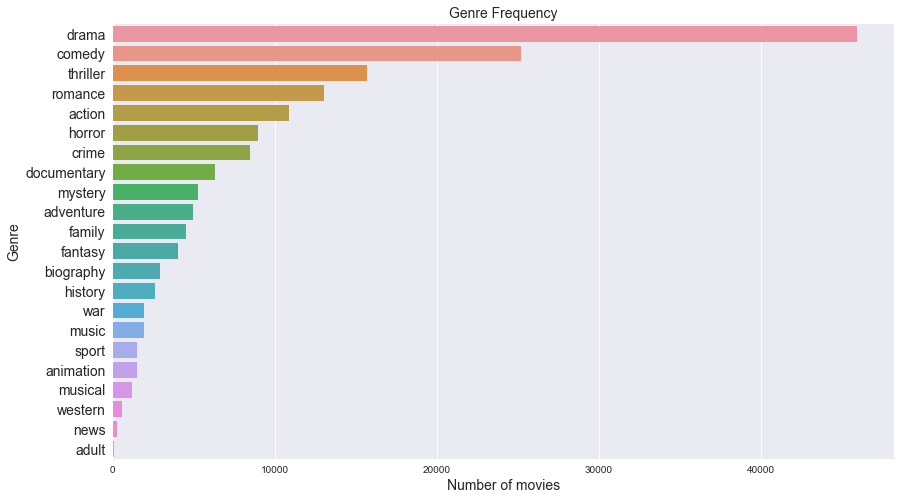

In [32]:
plt.figure(figsize=(14,8))
sns.barplot(list(distrib.values()), list(distrib.keys()), orient='h')
plt.xlabel('Number of movies', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.title('Genre Frequency',fontsize=14)
plt.yticks(fontsize=14)
plt.show()


In [33]:
# for ind, genre in enumerate(df_tri.genre):
#     if len(genre.split()) == 0:
#         print(ind)

In [34]:
df_tri = df_tri[df_tri['genre'] != ''] #getting rid of empty strings

## Trivia cleaning

In [35]:
# text = ' '.join(df_syn.synopsis)

# bigrams = find_bigrams(text, 30)
# print(bigrams)

bigrams = {'next day': 'nextday', 'new york': 'newyork', 'next morning': 'nextmorning', 
           'los angeles': 'losangeles', 'high school': 'highschool', 'doesnt want': 'doesntwant',
           'even though': 'eventhough', 'best friend': 'bestfriend', 'years ago': 'yearsago',
           'united states': 'unitedstates', 'one day': 'oneday', 'cell phone': 'cellphone',
           'phone call': 'phonecall', 'york city': 'yorkcity', 'doesnt know': 'doesntknow',
           'years later': 'yearslater', 'police officer': 'policeofficer', 'las vegas': 'lasvegas',
           'returns home': 'returnshome', 'san francisco': 'sanfrancisco', 'young woman': 'youngwoman',
           'parking lot': 'parkinglot', 'take care': 'takecare', 'first time': 'firsttime', 'young man': 'youngman',
           'go back': 'goback', 'looks like': 'lookslike', 'still alive': 'stillalive', 'hong kong': 'hongkong',
           'film ends': 'filmends'}

In [36]:
df_syn['synopsis'] = df_syn['synopsis'].map(lambda x: clean_text(x, bigrams=None,lemmatize=False, stem=False))

df_syn['genre'] = df_syn['genre'].map(lambda x: clean_text(x))

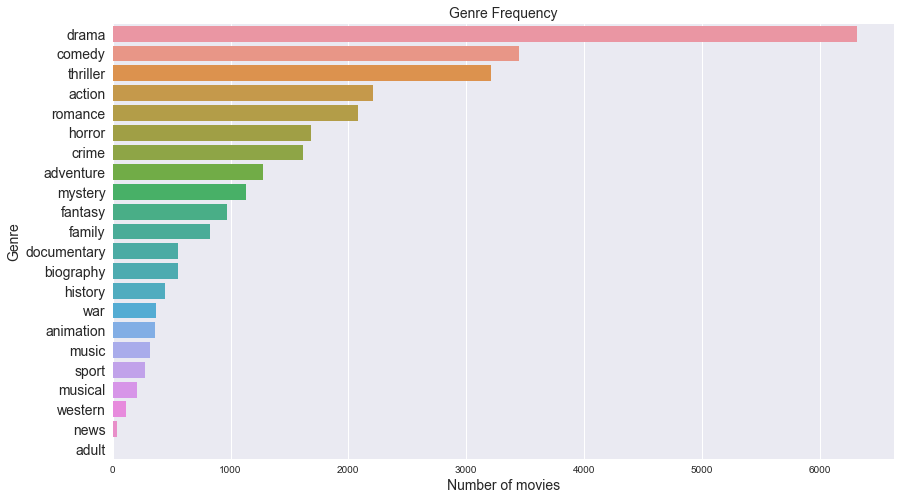

In [37]:
distrib = []
for genre in df_syn.genre:
    for i in genre.split():
        distrib.append(i)
        
from collections import Counter

distrib = dict(Counter(distrib).most_common())

plt.figure(figsize=(14,8))
sns.barplot(list(distrib.values()), list(distrib.keys()), orient='h')
plt.xlabel('Number of movies', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.title('Genre Frequency',fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [38]:
df_syn.head(20)

,genre,synopsis
0,comedy fantasy romance,leopold alexis elijah walker gareth thomas mou...
1,drama,vanishes covering african civil war roll film ...
2,horror mystery,sicily mob villagers drag five kicking screami...
3,drama,guy kills old lady turns
4,action,kat collins grown restless life rural utah dec...
5,drama,amber film photography collective decided work...
6,comedy,dont knooow cuz havnt seen mooovie
7,horror,father osullivan catholic priest lost faith ca...
8,horror,teacher vs student basketball game sally donne...
9,comedy horror,crawldaddy two kids travelling selling fine le...


The synopsis below is not very informative. I need to get rid of it and the ones like it.

In [39]:
print(df_syn.loc[3, 'synopsis'])

guy kills old lady turns


In [40]:
df_syn['length'] = df_syn.synopsis.apply(length) #separate column with length of the synopsis

Let's take a look at length distribution. I am going to get rid of outliers as well as very short texts. This will balance our data and hopefully improve model's accuracy

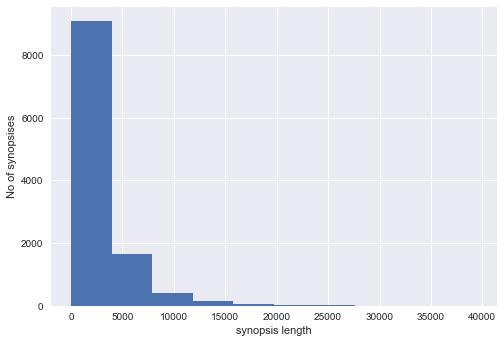

In [41]:
df_syn.length.hist()
plt.xlabel('synopsis length')
plt.ylabel('No of synopsises')
plt.show()

In [42]:
df_syn = df_syn[df_syn.length >= 500]
df_syn = df_syn[df_syn.length < 10000]

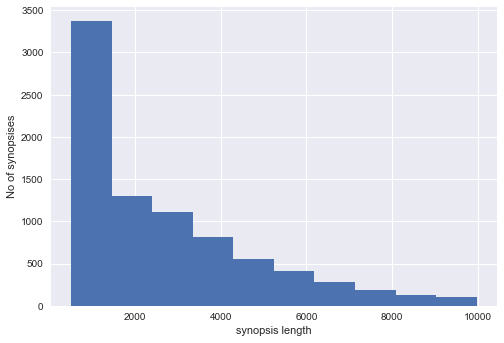

In [43]:
df_syn.length.hist()
plt.xlabel('synopsis length')
plt.ylabel('No of synopsises')
plt.show()

This looks a bit better. I am going to leave it as it is.

## Vectorize

I am going to make my own vectors to feed into embedding layer

In [44]:
import multiprocessing
from time import time
from gensim.models import Word2Vec

multiprocessing.cpu_count()

20

In [45]:
def w2v_vocab_and_train(df):
    
    '''trains Word2Vec model on provided text corpus
    returns Word2Vec model'''
    
    w2v_model = Word2Vec(min_count=1,
                         window=5,
                         size=128,
                         sample=6e-5, 
                         alpha=0.03, 
                         min_alpha=0.0007, 
                         negative=20,
                         workers=15)
    t = time()

    w2v_model.build_vocab(df, progress_per=10000)

    print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

    t = time()

    w2v_model.train(df_tri.summary, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

    print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
    
    w2v_model.init_sims(replace=True)
    
    vocab = w2v_model.wv.vocab
    print('Total number of words : ', len(vocab))
    
    return w2v_model

In [46]:
def embedding_matrix(df, w2v_model, vocab_size, embed_dim):
    
    '''Builds and embedding matrix from given dataframe to feed into embedding layer'''
    
    tok = Tokenizer()
    
    tok.fit_on_texts(df)
    
    vocab = w2v_model.wv.vocab
    
    words_vocab = list(vocab.keys())
    
    word_vec_dict = {}

    for word in words_vocab:
        word_vec_dict[word] = w2v_model.wv.get_vector(word) #creates word/vector dictionary

    embed_matrix = np.zeros(shape=(vocab_size,embed_dim))#make a matrix of zeros 
    
    #then replaces zeros with vectors learned by w2v model

    for word,i in tok.word_index.items():
        embed_vector = word_vec_dict.get(word)

        if embed_vector is not None:
            embed_matrix[i] = embed_vector

    return embed_matrix

## Preparing for modelling

In [47]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [48]:
from sklearn.model_selection import train_test_split,cross_validate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense , Flatten ,Embedding, Input, LSTM, Bidirectional, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MultiLabelBinarizer

In [49]:
def one_hot_labels(labels):
    
    '''one hot encodes labels
    returns df with labels as column names'''
    
    labels = labels.map(lambda x: x.split())
    
    one_hot = MultiLabelBinarizer()
    one_hot_df = pd.DataFrame(one_hot.fit_transform(labels), columns=one_hot.classes_)
    
    return one_hot_df

We need to find the maximum lenght of a text in our case. We will pad all reviews to have the same length. This will be required by Keras embedding layer.

In [50]:
def find_max_length(df):
    
    '''finds maximum length of the text in dataframe'''
    
    max_length = -1

    for i in df:
        if len(i) > max_length:
            max_length = len(i)

    return max_length

Here we prepare and pad out text so our model could read it.

In [51]:
def sequence_and_pad(df):
    
    '''Turns all texts from df into numerical sequences then pads them to match the longest text'''
    
    max_length = find_max_length(df)
    
    tok = Tokenizer()
    
    tok.fit_on_texts(df)

    encoded_summary = tok.texts_to_sequences(df)

    pad_summary = pad_sequences(encoded_summary, maxlen=max_length, padding='post')
    
    return pad_summary

## Trivia modelling

In [52]:
df_tri.summary = df_tri.summary.map(lambda x: x.split())#make lists of words from our clean texts

In [53]:
#train W2V model
w2v_model = w2v_vocab_and_train(df_tri.summary)

Time to build vocab: 0.16 mins
Time to train the model: 0.3 mins
Total number of words :  75713


In [54]:
#just check if it's working
w2v_model.wv.most_similar(positive=['school'])

[('high', 0.738111674785614),
 ('teachers', 0.7148510217666626),
 ('classmates', 0.7101846933364868),
 ('junior', 0.709505021572113),
 ('grade', 0.6884545087814331),
 ('teacher', 0.6767902374267578),
 ('elementary', 0.6733537912368774),
 ('seniors', 0.6731663942337036),
 ('classmate', 0.6651784181594849),
 ('schools', 0.6622570753097534)]

In [55]:
w2v_model.wv.get_vector('like')

array([ 0.05268456, -0.05823303,  0.04524685, -0.15890585, -0.18271904,
       -0.08960468, -0.14431311,  0.09846552,  0.08014829, -0.0003235 ,
       -0.03260517, -0.05539441,  0.05726688, -0.02519761,  0.05524447,
        0.05170987, -0.02169576,  0.00094465,  0.03417141, -0.00645771,
        0.06253369, -0.14309222,  0.01759904,  0.12740435, -0.10716701,
       -0.14613675, -0.09703553,  0.04287345, -0.20310912,  0.15632968,
       -0.02818059, -0.0488007 , -0.02833099,  0.01021304, -0.05144777,
        0.04971348, -0.05420893,  0.06927659, -0.0134877 , -0.09162863,
        0.01590047, -0.12283359, -0.05241814, -0.00368981,  0.02176867,
       -0.0905138 , -0.16375637, -0.05842626, -0.11988176,  0.0514471 ,
        0.02624454,  0.01664037, -0.01722308, -0.0576795 ,  0.06343875,
        0.12269244, -0.06781248,  0.01576784, -0.10830003, -0.00194563,
        0.02904638,  0.0242167 , -0.03571506, -0.00956072, -0.06438737,
        0.00661366,  0.15578012, -0.09109946, -0.19013241, -0.01

Now we prepare everything for our model input

In [56]:
max_length = find_max_length(df_tri.summary) #required NN model parameter

vocab_size = len(w2v_model.wv.vocab) + 1 # total number of words

embed_dim = 128 # length of our input layer

n_classes = len(one_hot_labels(df_tri.genre).columns)# number of genres to predict

embed_matrix = embedding_matrix(df_tri.summary, w2v_model, vocab_size, embed_dim) #our words with corresponding weights

In [57]:
embed_matrix.shape

(75714, 128)

In [58]:
# prepare out train and validation data

X = sequence_and_pad(df_tri.summary)
y = one_hot_labels(df_tri.genre).values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=111)

I am going to use Bidirectional LSTM layer as it proves to be one of the best at recognizing patterns in text data.

In [59]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[embed_matrix], input_length=max_length, trainable=False))

model.add(Bidirectional(LSTM(32, return_sequences=True)))

model.add(Dropout(0.3)) #drop random connections to prevent overfitting

model.add(Bidirectional(LSTM(16)))

model.add(Dropout(0.3))

model.add(BatchNormalization())#Batch normalization offers some regularization effect, reducing generalization error

model.add(Dense(n_classes, activation='sigmoid'))
# sigmoid function give scores for the occurrence of genres, which would be independent of occurrences of any other movie genre

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 38, 128)           9691392   
_________________________________________________________________
bidirectional (Bidirectional (None, 38, 64)            41216     
_________________________________________________________________
dropout (Dropout)            (None, 38, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 22)                7

In [61]:
# specify batch size and epochs for training.
epochs=25
batch_size=128

In [62]:
# fitting the model.
model.fit(x_train,y_train, epochs=epochs,batch_size=batch_size,validation_data=(x_test,y_test))

Train on 66984 samples, validate on 16746 samples
Epoch 1/25
66984/66984 [==============================] - 10s 142us/sample - loss: 0.3237 - accuracy: 0.8748 - val_loss: 0.2043 - val_accuracy: 0.9206
Epoch 2/25
66984/66984 [==============================] - 4s 62us/sample - loss: 0.1974 - accuracy: 0.9236 - val_loss: 0.1859 - val_accuracy: 0.9268
Epoch 3/25
66984/66984 [==============================] - 4s 64us/sample - loss: 0.1921 - accuracy: 0.9248 - val_loss: 0.1848 - val_accuracy: 0.9269
Epoch 4/25
66984/66984 [==============================] - 4s 62us/sample - loss: 0.1894 - accuracy: 0.9257 - val_loss: 0.1819 - val_accuracy: 0.9279
Epoch 5/25
66984/66984 [==============================] - 4s 63us/sample - loss: 0.1879 - accuracy: 0.9261 - val_loss: 0.1813 - val_accuracy: 0.9277
Epoch 6/25
66984/66984 [==============================] - 4s 62us/sample - loss: 0.1865 - accuracy: 0.9265 - val_loss: 0.1810 - val_accuracy: 0.9279
Epoch 7/25
66984/66984 [==============================

In [63]:
# model.save('my_model')

<AxesSubplot:>

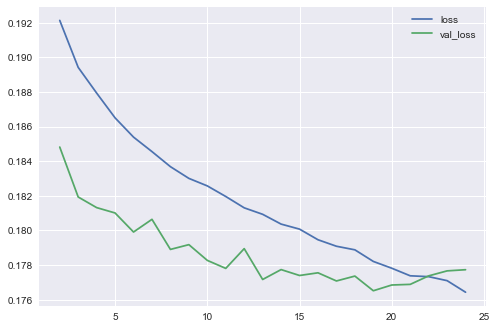

In [64]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']][2:].plot()

<AxesSubplot:>

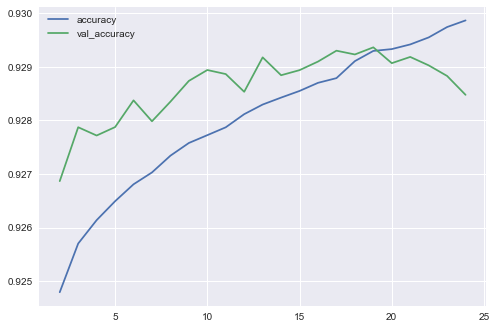

In [65]:
loss[['accuracy', 'val_accuracy']][2:].plot()

Model shows nice validation accuracy. But what does it really mean for multiclass problem. Lets turn our results into text and compare with actual data.

In [66]:
# model = tf.keras.models.load_model('my_model')

In [67]:
actual = y_test
predictions = model.predict(x_test)

Below we see a list of probabilities for our first summary. We need to find some level at which we can accept that this genre belongs to given movie.

In order to do that I am going to use the F-score on different levels. The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall.

In [68]:
predictions[1]

array([2.8271568e-03, 2.2094444e-04, 1.1243639e-02, 5.2079619e-03,
       3.1314269e-03, 8.1895429e-01, 3.1268355e-03, 4.2614387e-03,
       4.7618973e-01, 8.5983954e-02, 2.2908991e-02, 2.0684032e-03,
       1.9871169e-03, 2.3338983e-02, 3.1978335e-02, 2.8604495e-03,
       3.4027384e-05, 5.0346708e-01, 1.0495230e-02, 3.7066615e-03,
       4.2533726e-04, 1.6305575e-04], dtype=float32)

In [69]:
def apply_trh(list_, treshold=0.3):
    '''Applies filter to list of probabilities:
    assignes 1 to items larger then threshold value, 
    assignes 0 to the rest.
    Returns updated list'''
    
    out = []
    for item in list_:
        if item >= treshold:
            out.append(1)
        else:
            out.append(0)
    return out 
        

In [70]:
from sklearn.metrics import f1_score

preds = model.predict(x_test)
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for thr in thresholds:
    pred = preds.copy()
    
    pred = [apply_trh(x,treshold=thr) for x in pred]
  
    f1 = f1_score(y_test, pred, average='micro')
   
    print('--------------------------------------------------')
    print('F1-measure: {:.4f} for {} threshold'.format(f1, thr))

--------------------------------------------------
F1-measure: 0.5171 for 0.1 threshold
--------------------------------------------------
F1-measure: 0.5764 for 0.2 threshold
--------------------------------------------------
F1-measure: 0.5797 for 0.3 threshold
--------------------------------------------------
F1-measure: 0.5546 for 0.4 threshold
--------------------------------------------------
F1-measure: 0.5039 for 0.5 threshold
--------------------------------------------------
F1-measure: 0.4219 for 0.6 threshold
--------------------------------------------------
F1-measure: 0.3165 for 0.7 threshold
--------------------------------------------------
F1-measure: 0.1952 for 0.8 threshold
--------------------------------------------------
F1-measure: 0.0742 for 0.9 threshold


In [71]:
predictions = [apply_trh(x) for x in predictions]
genres = list(one_hot_labels(df_tri.genre).columns)

In [72]:
def reverse_dummies(dummies):
    '''reverse one hot encoded values
    returns list of lists with values'''
    
    return  [i for i, j in zip(genres, dummies) if j == 1]

predictions = [reverse_dummies(x) for x in predictions]
actual = [reverse_dummies(x) for x in actual]

In [73]:
actual_vs_preds = pd.DataFrame()
actual_vs_preds['actual'] = actual
actual_vs_preds['predictions'] = predictions

In [74]:
actual_vs_preds.head(50)

,actual,predictions
0,[drama],"[adventure, drama, family]"
1,"[comedy, romance]","[comedy, drama, romance]"
2,"[action, adventure]","[action, comedy, crime, drama, thriller]"
3,[drama],"[comedy, horror]"
4,[horror],"[drama, horror]"
5,"[adventure, animation, comedy, family, fantasy]","[adventure, comedy]"
6,"[comedy, drama, romance]","[comedy, drama]"
7,[drama],[drama]
8,"[comedy, music]","[documentary, music]"
9,"[horror, thriller]","[comedy, fantasy, horror]"


## Synopsis modelling

In [75]:
df_syn.synopsis = df_syn.synopsis.map(lambda x: x.split())

In [76]:
w2v_model_2 = w2v_vocab_and_train(df_syn.synopsis)

Time to build vocab: 0.21 mins
Time to train the model: 0.34 mins
Total number of words :  99322


In [77]:
w2v_model_2.wv.most_similar(positive=['school'])

[('grade', 0.751615047454834),
 ('teachers', 0.7260676622390747),
 ('seniors', 0.7028236985206604),
 ('junior', 0.6977225542068481),
 ('schools', 0.6925023794174194),
 ('elementary', 0.6690067052841187),
 ('substitute', 0.6639212369918823),
 ('boarding', 0.6597440242767334),
 ('classmates', 0.6554762125015259),
 ('senior', 0.6533634066581726)]

In [78]:
w2v_model_2.wv.get_vector('like')

array([ 0.14160629, -0.08562592,  0.03965658, -0.11859296, -0.06752829,
       -0.04812404,  0.00214354, -0.02762758, -0.04451223,  0.02234822,
        0.04314379, -0.08799729,  0.09798771, -0.10826664,  0.01861241,
        0.01334446, -0.00639286,  0.1157543 , -0.04436628, -0.17982946,
        0.006863  , -0.02961881,  0.07578628,  0.17573068, -0.02627992,
       -0.1551194 ,  0.07221949, -0.0928772 , -0.12712029,  0.11695955,
       -0.00874289, -0.0407464 ,  0.00574969, -0.05439276, -0.08393162,
       -0.0445708 , -0.1224477 ,  0.08609021, -0.03356223, -0.16799122,
       -0.02246755, -0.00510103, -0.08574577, -0.05809294, -0.01599899,
        0.01315146,  0.06369817, -0.00485771, -0.1389622 , -0.0771301 ,
       -0.10212361,  0.02781782, -0.03703211, -0.01926325,  0.01332463,
       -0.21333082, -0.04235957,  0.11927152, -0.03645523,  0.13997796,
       -0.00235607, -0.10317247, -0.10093212, -0.13050623, -0.11795817,
       -0.04194839,  0.05699179, -0.02334211, -0.01150744,  0.11

In [79]:
w2v_model_2.wv.most_similar('family')

[('familys', 0.6265244483947754),
 ('father', 0.625190019607544),
 ('matriarch', 0.6047267913818359),
 ('relatives', 0.5980164408683777),
 ('patriarch', 0.5815290212631226),
 ('parents', 0.5784037113189697),
 ('household', 0.5751878023147583),
 ('youngest', 0.5566761493682861),
 ('extended', 0.5550682544708252),
 ('eldest', 0.5455334782600403)]

In [80]:
max_length_2 = find_max_length(df_syn.synopsis)

vocab_size_2 = len(w2v_model_2.wv.vocab) + 1 # total number of words

embed_dim_2 = 128 # embedding dimension

n_classes_2 = len(one_hot_labels(df_syn.genre).columns)

embed_matrix_2 = embedding_matrix(df_syn.synopsis, w2v_model_2, vocab_size_2, embed_dim_2)

In [81]:
n_classes_2

21

In [82]:
X = sequence_and_pad(df_syn.synopsis)
y = one_hot_labels(df_syn.genre).values

In [99]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [100]:
model_2 = Sequential()

model_2.add(Embedding(input_dim=vocab_size_2, output_dim=embed_dim_2, weights=[embed_matrix_2], input_length=max_length_2, trainable=False))

model_2.add(Bidirectional(LSTM(32, return_sequences=False)))

model_2.add(Dropout(0.1))

model_2.add(BatchNormalization())

model_2.add(Dense(n_classes_2, activation='sigmoid'))

model_2.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [101]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1615, 128)         12713344  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1365      
Total params: 12,756,181
Trainable params: 42,709
Non-trainable params: 12,713,472
_________________________________________________________________


In [102]:
# specify batch size and epochs for training.
epochs=30
batch_size=256

In [103]:
# fitting the model.
model_2.fit(x_train,y_train, epochs=epochs,batch_size=batch_size,validation_data=(x_test,y_test))

Train on 6608 samples, validate on 1653 samples
Epoch 1/30
6608/6608 [==============================] - 6s 940us/sample - loss: 0.7086 - accuracy: 0.5361 - val_loss: 0.6559 - val_accuracy: 0.8829
Epoch 2/30
6608/6608 [==============================] - 4s 597us/sample - loss: 0.6352 - accuracy: 0.6608 - val_loss: 0.5932 - val_accuracy: 0.8869
Epoch 3/30
6608/6608 [==============================] - 4s 602us/sample - loss: 0.5483 - accuracy: 0.8087 - val_loss: 0.5010 - val_accuracy: 0.8852
Epoch 4/30
6608/6608 [==============================] - 4s 603us/sample - loss: 0.4465 - accuracy: 0.8791 - val_loss: 0.4071 - val_accuracy: 0.8859
Epoch 5/30
6608/6608 [==============================] - 4s 596us/sample - loss: 0.3609 - accuracy: 0.8924 - val_loss: 0.3456 - val_accuracy: 0.8858
Epoch 6/30
6608/6608 [==============================] - 4s 597us/sample - loss: 0.3099 - accuracy: 0.8952 - val_loss: 0.3091 - val_accuracy: 0.8887
Epoch 7/30
6608/6608 [==============================] - 4s 598us

In [104]:
# model_2.save('my_model_2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model_2\assets


<AxesSubplot:>

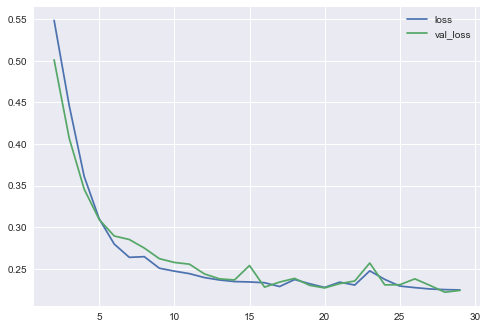

In [105]:
loss_2 = pd.DataFrame(model_2.history.history)
loss_2[['loss', 'val_loss']][2:].plot()

<AxesSubplot:>

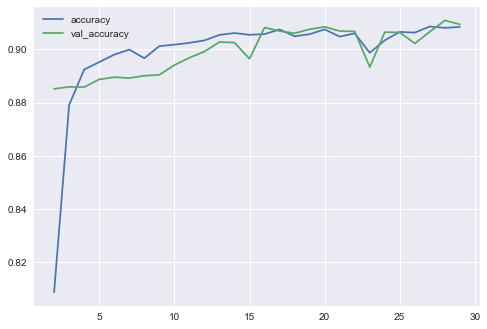

In [106]:
loss_2[['accuracy', 'val_accuracy']][2:].plot()

In [91]:
# model_2 = tf.keras.models.load_model('my_model_2')

In [107]:
actual_2 = y_test
predictions_2 = model_2.predict(x_test)

In [108]:
predictions_2[1]

array([0.00631773, 0.00827481, 0.00323178, 0.02500881, 0.39342663,
       0.03074602, 0.00798566, 0.789581  , 0.01913959, 0.02047212,
       0.00702533, 0.04181992, 0.04003656, 0.01180624, 0.03862275,
       0.00330225, 0.45375243, 0.01017664, 0.0774362 , 0.00385976,
       0.0020665 ], dtype=float32)

In [109]:
preds = model_2.predict(x_test)
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for thr in thresholds:
    pred = preds.copy()
    
    pred = [apply_trh(x,treshold=thr) for x in pred]
  
    f1 = f1_score(y_test, pred, average='micro')
   
    print('--------------------------------------------------')
    print('F1-measure: {:.4f} for {} threshold'.format(f1, thr))

--------------------------------------------------
F1-measure: 0.5383 for 0.1 threshold
--------------------------------------------------
F1-measure: 0.5888 for 0.2 threshold
--------------------------------------------------
F1-measure: 0.5932 for 0.3 threshold
--------------------------------------------------
F1-measure: 0.5804 for 0.4 threshold
--------------------------------------------------
F1-measure: 0.5402 for 0.5 threshold
--------------------------------------------------
F1-measure: 0.4658 for 0.6 threshold
--------------------------------------------------
F1-measure: 0.3493 for 0.7 threshold
--------------------------------------------------
F1-measure: 0.2015 for 0.8 threshold
--------------------------------------------------
F1-measure: 0.0566 for 0.9 threshold


In [110]:
predictions_2 = [apply_trh(x, 0.3) for x in predictions_2]
predictions_2 = [reverse_dummies(x) for x in predictions_2]
actual_2 = [reverse_dummies(x) for x in actual_2]

In [111]:
actual_vs_preds_2 = pd.DataFrame()

In [112]:
actual_vs_preds_2['actual'] = actual_2
actual_vs_preds_2['predictions'] = predictions_2

In [114]:
actual_vs_preds_2[300:350]

,actual,predictions
300,[documentary],"[biography, documentary, news]"
301,"[action, comedy, sport]","[action, comedy, documentary, sport]"
302,"[action, adult, adventure, comedy, drama, musi...","[action, documentary, sport]"
303,"[biography, documentary, news]","[biography, documentary, news]"
304,"[crime, documentary, fantasy, mystery]","[animation, crime, documentary]"
305,[documentary],"[biography, documentary]"
306,[documentary],"[biography, documentary, news]"
307,[documentary],[documentary]
308,"[biography, comedy, documentary]","[biography, documentary, news]"
309,"[animation, documentary, fantasy, news, thriller]","[documentary, fantasy]"


## Conclusion

Trivia model turned out to be slightly better. The results for both models are pretty satisfying. The best threshold turned out to be 0.3 which means genre must get 30% probability of occurence to be assigned to a movie.  The F1 score of ~0.6 is pretty good considering number of labels: 22 for tirvia and 21 for synopsis.

Interesting that applying stemming and lemmatization as well as bigrams did not improve model's preformance but even made it a bit worse. 

Future work would be:

- Train data on more examples
- Test more model architechtures